In [362]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

from torchvision import models

import torchio as tio

In [363]:
# elastic_transform = tio.Compose([
#     tio.RandomElasticDeformation(num_control_points=7, max_displacement=5, locked_borders=4),  # Adjust as needed
# ])

class RoofSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            label_dir (str): Path to the directory with corresponding labels.
            transform (callable, optional): Optional transform to be applied
                on an image and its label.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))
        # Filter out images without corresponding labels
        self.image_filenames = [
            f for f in self.image_filenames if f in self.label_filenames
        ]
        self.label_filenames = [
            f for f in self.label_filenames if f in self.image_filenames
        ]

        if len(self.image_filenames) != len(self.label_filenames):
            raise ValueError(
                "Mismatch between number of images and labels after filtering. "
                f"Images: {len(self.image_filenames)}, Labels: {len(self.label_filenames)}"
            )

        self.transform = transform
        # self.elastic_transform = elastic_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        image = np.array(image)
        label = np.array(label)

        # if self.elastic_transform:
        #     image = self.elastic_transform(image=image)["image"]
        #     label = self.elastic_transform(image=label)["image"]  # Apply elastic transform to label as well (if needed)

        if self.transform:
            # Apply the transform pipeline to the image and label
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']
        
        # Normalize labels to be binary (0 or 1)
        label = (label > 0).float()

        # Add an extra dimension to match the output shape [batch_size, 1, height, width]
        label = label.unsqueeze(0)  # Adds the channel dimension

        return image, label

# Define a simple CNN architecture for segmentation
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc2_pool)
        
        # Decoder
        up2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        # Output
        out = self.out(dec1)
        return out

class ResNetUNet(nn.Module):
    def __init__(self, num_classes=1, freeze_encoder=True, dropout_rate=0.5):
        super(ResNetUNet, self).__init__()

        # Load pre-trained ResNet-18
        resnet = models.resnet18(pretrained=True)
        
        # Remove fully connected layer and average pooling
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze layers manually
        if freeze_encoder:
            for param in resnet.conv1.parameters():
                param.requires_grad = False
            for param in resnet.layer1.parameters():  # Freeze layer1
                param.requires_grad = False
            for param in resnet.layer2.parameters():  # Freeze layer2
                param.requires_grad = False

        # Decoder with dropout
        self.up2 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout added here
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Dropout added here
        )

        self.up1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout added here
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Dropout added here
        )

        self.final_upsample = nn.Upsample(size=(128, 128), mode='bilinear', align_corners=True)
        self.out = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        enc = self.encoder(x)
        up2 = self.up2(enc)
        dec2 = self.dec2(up2)
        up1 = self.up1(dec2)
        dec1 = self.dec1(up1)
        out = self.final_upsample(dec1)
        out = self.out(out)
        return out



In [364]:

# Directories for images and labels
image_dir = "./images"
label_dir = "./labels"

# # Define transformations (resize and normalize images)
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize all images and labels to 128x128
#     transforms.ToTensor(),         # Convert images to PyTorch tensors
# ])



# Define the Albumentations augmentation pipeline
transform = A.Compose([
    A.Resize(128, 128),  # Resize all images and labels to 128x128
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.8, 1.2), shear=(-10, 10), rotate=(-30, 30), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize image channels
    ToTensorV2()  # Convert both images and labels to PyTorch tensors
])

# Initialize the dataset with the Albumentations transform
dataset = RoofSegmentationDataset(image_dir, label_dir, transform=transform)


# # Create dataset and dataloaders
# dataset = RoofSegmentationDataset(image_dir, label_dir, transform=transform)

TRAIN_FRACTION = 0.8
train_size = int(TRAIN_FRACTION * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # remaining 20% for testing

# Split the dataset into training and testing subsets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for both sets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# data_loader = DataLoader(dataset, batch_size=4, shuffle=True)



In [365]:
model = ResNetUNet(num_classes=1, freeze_encoder=True)

In [366]:
# model = SimpleUNet()



train_losses = []
test_losses = []
lr_history = []
learning_rate = 1e-4
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=1e-3  # Weight decay for L2 regularization
)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',          # Minimize the validation loss
#     factor=0.5,          # Reduce learning rate by half when plateau is detected
#     patience=5,          # Wait for 5 epochs with no improvement before reducing LR
#     threshold=1e-3,      # Threshold for considering a plateau in validation loss
#     verbose=True,        # Enable printing when the LR is reduced
#     min_lr=1e-6          # Set a lower bound for the learning rate
# )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)


In [367]:
# Visualization function
def visualize_results(images, labels, outputs):
    """ Visualize input images, labels, and model outputs side-by-side """
    batch_size = images.size(0)
    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        label = labels[i].squeeze(0).cpu().numpy()
        output = outputs[i].squeeze(0).detach().cpu().numpy()
        # print(f"output {i}", output)
        rounded_output =  output.round()


        fig, ax = plt.subplots(1, 4, figsize=(12, 4))
        ax[0].imshow(image)
        ax[0].set_title("Input Image")
        ax[0].axis("off")

        ax[1].imshow(label, cmap="gray")
        ax[1].set_title("Ground Truth Label")
        ax[1].axis("off")

        ax[2].imshow(output, cmap="gray")
        ax[2].set_title("Model Output")
        ax[2].axis("off")

        ax[3].imshow(rounded_output, cmap="gray")
        ax[3].set_title("Rounded Output")
        ax[3].axis("off")

        plt.show()

torch.Size([128, 128])


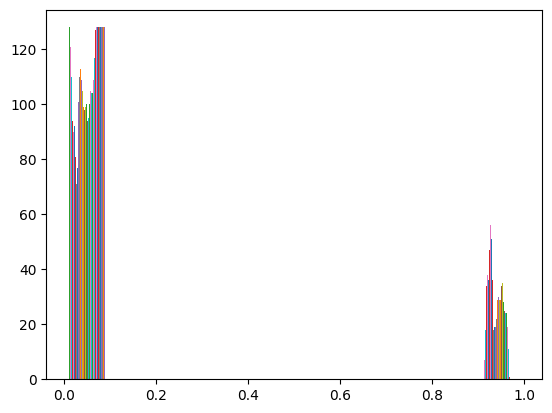

In [368]:
for images, labels in test_dataloader:
  image = images[0] #4 images/batch, 3 color channels, 128 x 128 images
  label = labels[0][0]
  print(label.shape)
  plt.hist(label)
  rounded_tensor = label.round()
  break

In [ ]:
def get_loss_from_dataloader(model, dataloader, criterion, device):
    model.eval()

    # Initialize loss
    test_loss = 0.0

    # Disable gradient computation for testing
    with torch.no_grad():
        for batch in dataloader:
            # Assuming batch is a tuple (inputs, targets)
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss for the batch
            loss = criterion(outputs, targets)

            # Accumulate loss
            test_loss += loss.item()

    # Compute average loss over the entire test set
    average_loss = test_loss / len(test_dataloader)
    # print("test loss: ", average_loss)
    return average_loss

def dice_loss(pred, target, smooth=1e-6):
    # Flatten the tensors to treat them as 1D arrays
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target)

    # Dice coefficient = 2 * intersection / (union + smooth)
    dice = 2. * intersection / (union + smooth)
    
    return 1 - dice  # We want to minimize the loss, so return (1 - dice coefficient)


class CombinedLoss(torch.nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_loss = torch.nn.BCEWithLogitsLoss()  # BCE loss
        self.dice_loss = dice_loss  # Dice loss
        
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, outputs, targets):
        bce = self.bce_loss(outputs, targets)
        dice = self.dice_loss(outputs, targets)
        return self.bce_weight * bce + self.dice_weight * dice

def train_unet(model, train_dataloader, test_dataloader, num_epochs=10, learning_rate=1e-4, device='cuda', train_losses=[], test_losses=[], scheduler=None, lr_history=[]):
    """
    Train a U-Net model with a given DataLoader.
    
    Parameters:
    - model: The U-Net model (should be a PyTorch nn.Module).
    - dataloader: DataLoader providing the training dataset.
    - num_epochs: Number of epochs to train the model.
    - learning_rate: Learning rate for the optimizer.
    - device: Device to run the model ('cuda' or 'cpu').
    """
    
    # Move model to the specified device
    model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for segmentation tasks
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set the model to training mode
    model.train()

    # Iterate over the specified number of epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # Progress bar using tqdm for better visualization
        for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}'):
            # Move the inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: Get model outputs
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backward pass: Compute gradients
            loss.backward()
            
            # Update the model weights
            optimizer.step()
            
            # Accumulate loss for the current batch
            running_loss += loss.item()
        
        # Print average loss for the epoch
        avg_loss = running_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        test_loss = get_loss_from_dataloader(model, test_dataloader, criterion, device='cpu')
        test_losses.append(test_loss)
        # Adjust learning rate based on the test loss
        scheduler.step(test_loss)
        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        model.train()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}, Learning Rate: {current_lr}")
        
    print("Training finished")

In [370]:
len(dataset)


25

In [ ]:
# learning_rate = 1e-5
train_unet(model, train_dataloader, test_dataloader, num_epochs=2000, learning_rate=learning_rate, device='cpu', train_losses=train_losses, test_losses=test_losses, scheduler=scheduler, lr_history=lr_history)

Epoch 1/2000: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/2000], Train Loss: 0.6505, Test Loss: 0.5691, Learning Rate: 9.928263080827662e-05


Epoch 2/2000: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch [2/2000], Train Loss: 0.5419, Test Loss: 0.5096, Learning Rate: 9.942459163682084e-05


Epoch 3/2000: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch [3/2000], Train Loss: 0.5058, Test Loss: 0.4667, Learning Rate: 9.951710060517293e-05


Epoch 4/2000: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch [4/2000], Train Loss: 0.4851, Test Loss: 0.4756, Learning Rate: 9.949869045312417e-05


Epoch 5/2000: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch [5/2000], Train Loss: 0.4617, Test Loss: 0.4842, Learning Rate: 9.948039659852033e-05


Epoch 6/2000: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch [6/2000], Train Loss: 0.4433, Test Loss: 0.4944, Learning Rate: 9.945836853662743e-05


Epoch 7/2000: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch [7/2000], Train Loss: 0.4279, Test Loss: 0.4296, Learning Rate: 9.959071206152464e-05


Epoch 8/2000: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch [8/2000], Train Loss: 0.4048, Test Loss: 0.4778, Learning Rate: 9.949397206086662e-05


Epoch 9/2000: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch [9/2000], Train Loss: 0.4162, Test Loss: 0.4178, Learning Rate: 9.961296657217527e-05


Epoch 10/2000: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch [10/2000], Train Loss: 0.3825, Test Loss: 0.3673, Learning Rate: 9.970067453752196e-05


Epoch 11/2000: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch [11/2000], Train Loss: 0.3721, Test Loss: 0.4456, Learning Rate: 9.955971182808221e-05


Epoch 12/2000: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch [12/2000], Train Loss: 0.3856, Test Loss: 0.3834, Learning Rate: 9.967402745373893e-05


Epoch 13/2000: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch [13/2000], Train Loss: 0.3703, Test Loss: 0.4055, Learning Rate: 9.963537572944439e-05


Epoch 14/2000: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch [14/2000], Train Loss: 0.3835, Test Loss: 0.4175, Learning Rate: 9.961355085444093e-05


Epoch 15/2000: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch [15/2000], Train Loss: 0.3841, Test Loss: 0.3782, Learning Rate: 9.968271325602197e-05


Epoch 16/2000: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch [16/2000], Train Loss: 0.3576, Test Loss: 0.3860, Learning Rate: 9.966948090532482e-05


Epoch 17/2000: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch [17/2000], Train Loss: 0.3756, Test Loss: 0.3801, Learning Rate: 9.967958723934963e-05


Epoch 18/2000: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch [18/2000], Train Loss: 0.3611, Test Loss: 0.3693, Learning Rate: 9.969748052093468e-05


Epoch 19/2000: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch [19/2000], Train Loss: 0.3561, Test Loss: 0.4034, Learning Rate: 9.963904051707158e-05


Epoch 20/2000: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch [20/2000], Train Loss: 0.3405, Test Loss: 0.3984, Learning Rate: 9.964801611991505e-05


Epoch 21/2000: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch [21/2000], Train Loss: 0.3495, Test Loss: 0.3747, Learning Rate: 9.968860350795762e-05


Epoch 22/2000: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch [22/2000], Train Loss: 0.3521, Test Loss: 0.3526, Learning Rate: 9.97241438985194e-05


Epoch 23/2000: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch [23/2000], Train Loss: 0.3492, Test Loss: 0.3853, Learning Rate: 9.967068959188758e-05


Epoch 24/2000: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch [24/2000], Train Loss: 0.3347, Test Loss: 0.3987, Learning Rate: 9.964744090806867e-05


Epoch 25/2000: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch [25/2000], Train Loss: 0.3217, Test Loss: 0.3915, Learning Rate: 9.966005328085648e-05


Epoch 26/2000: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch [26/2000], Train Loss: 0.3170, Test Loss: 0.3518, Learning Rate: 9.972542505182857e-05


Epoch 27/2000: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Epoch [27/2000], Train Loss: 0.3219, Test Loss: 0.3777, Learning Rate: 9.968350262507661e-05


Epoch 28/2000: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Epoch [28/2000], Train Loss: 0.3332, Test Loss: 0.3334, Learning Rate: 9.975332432863021e-05


Epoch 29/2000: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch [29/2000], Train Loss: 0.3094, Test Loss: 0.3470, Learning Rate: 9.973281459447281e-05


Epoch 30/2000:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
torch.save(model, "dida_model.pth")

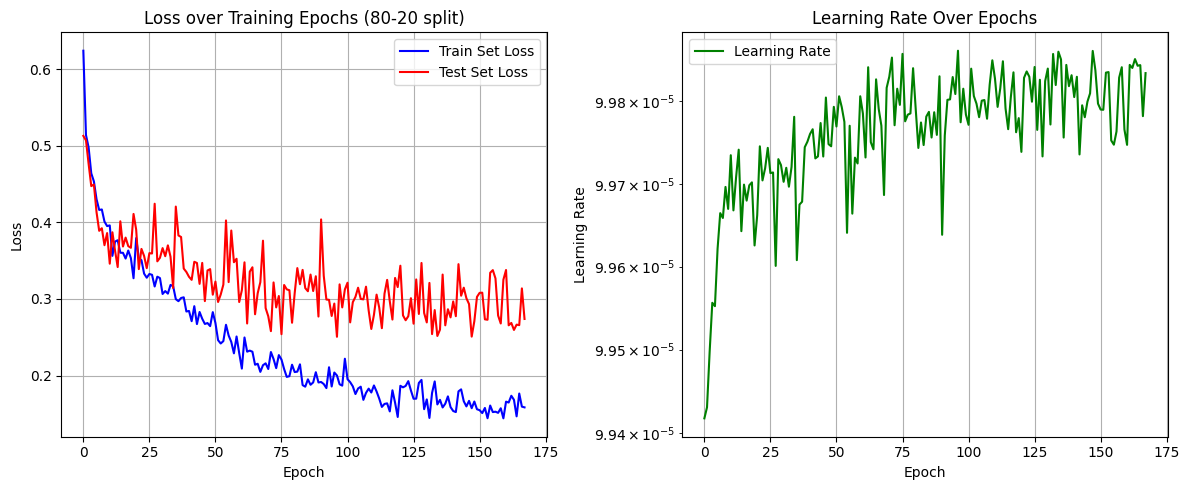

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the loss curves
axs[0].plot(train_losses, color='b', label="Train Set Loss")
axs[0].plot(test_losses, color='r', label="Test Set Loss")
axs[0].set_title(f'Loss over Training Epochs ({round(TRAIN_FRACTION*100)}-{round((1 - TRAIN_FRACTION)*100)} split)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)
axs[0].legend()

# Plot the learning rate history
axs[1].plot(lr_history, color='g', label="Learning Rate")
axs[1].set_title('Learning Rate Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].grid(True)
axs[1].set_yscale('log')
axs[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


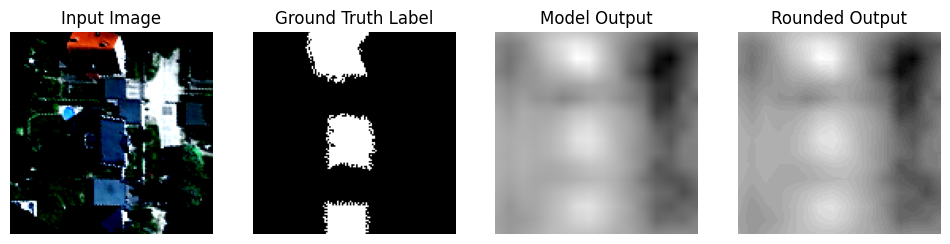

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.186841].


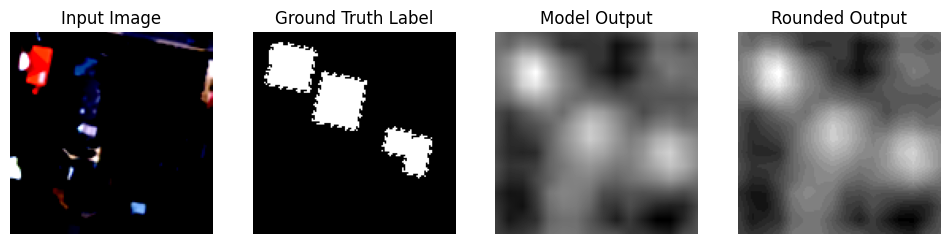

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


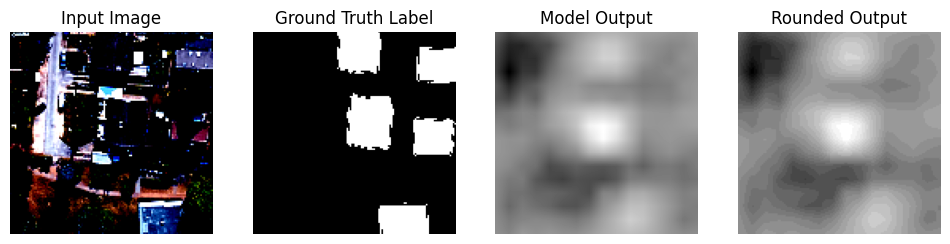

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831371].


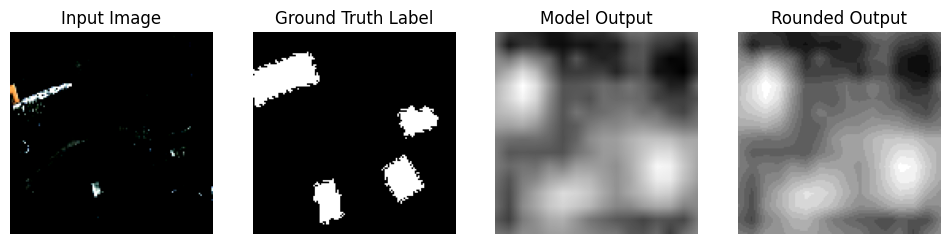

In [ ]:
# Check dataset loading and model output
for images, labels in test_dataloader:
    outputs = model(images)
    visualize_results(images, labels, outputs)
    break